In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [13]:
# Data collection
df = pd.read_csv('/Users/Dipti/Downloads/apple.csv')


In [14]:

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099450,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10773 entries, 0 to 10772
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10773 non-null  object 
 1   Open       10773 non-null  float64
 2   High       10773 non-null  float64
 3   Low        10773 non-null  float64
 4   Close      10773 non-null  float64
 5   Adj Close  10773 non-null  float64
 6   Volume     10773 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 589.3+ KB


In [16]:
closed_prices = df["Close"] #get only Close values
closed_prices

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10768    187.649994
10769    187.869995
10770    189.460007
10771    189.699997
10772    182.910004
Name: Close, Length: 10773, dtype: float64

In [17]:
seq_len=15
mm=MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[...,None]).squeeze() # add a dimension to list and again squeeze back

In [18]:
X=[]  #data
Y=[]  #target

for i in range(len(scaled_price)-seq_len):
        X.append(scaled_price[i:i+seq_len])
        Y.append(scaled_price[i+seq_len])
print(X[0])
print(Y[0])

[0.00040347 0.00036937 0.00032391 0.00033811 0.00035517 0.0003921
 0.00042335 0.00045177 0.0004887  0.0005569  0.00056826 0.00054837
 0.00052564 0.00053417 0.00051712]
0.00048302225107024716


In [19]:
X=np.array(X)[...,None]
Y=np.array(Y)[...,None]

train_X = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_Y= torch.from_numpy(Y[:int(0.8 * X.shape[0])]).float()

test_X = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_Y = torch.from_numpy(Y[int(0.8 * X.shape[0]):]).float()

print(train_X.shape , test_X.shape)
print(train_Y.shape , test_Y.shape)

torch.Size([8606, 15, 1]) torch.Size([2152, 15, 1])
torch.Size([8606, 1]) torch.Size([2152, 1])


In [20]:
#Building LSTM model

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 57)

optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [21]:
#Training model

num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_X)
    loss = loss_fn(output , train_Y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

model.eval()
with torch.no_grad():
    output = model(test_X)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_Y.numpy())

10 epoch loss 0.0014817889
20 epoch loss 0.0020598846
30 epoch loss 0.0010180313
40 epoch loss 0.0010992063
50 epoch loss 0.0009481391
60 epoch loss 0.00092843926
70 epoch loss 0.00087786326
80 epoch loss 0.000842467
90 epoch loss 0.0008027738


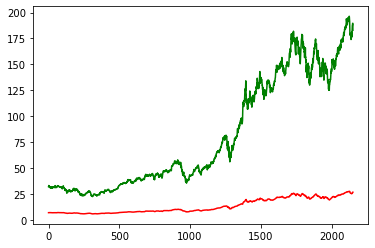

In [22]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.show()